In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [5]:
client = dask.distributed.Client()

/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32867 instead
  warnings.warn(


In [2]:
online_group = "zc-emu-1year-run-segmented-v3-online"
offline_group = "zc-emu-1year-run-segmented-v2-offline"

In [7]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [5]:
def _prepare_global_average(group, field):
    data = common.open_group(group)
    average_dims = list(set(data[field].dims) - set(["time", "z"]))
    field_data = data[field]
    if "online" in group:
        field_data = field_data.isel(time=slice(-1))

    return vcm.weighted_average(field_data, grid.area, dims=average_dims)

In [9]:
fields = ["air_temperature", "specific_humidity", "cloud_water_mixing_ratio", "total_precipitation"]

In [10]:
args = list(product([online_group, offline_group], fields))


In [ ]:

jobs = [delayed(_prepare_global_average)(g, f) for g, f in args]
to_load = Parallel(n_jobs=8)(jobs)

In [7]:
arg_to_load_map = {a: v for a, v in zip(args, to_load)}

In [11]:
@common.memoize_xarray_out
def get_global_average(group, field):
    return arg_to_load_map[(group, field)].load()

In [12]:
results = [get_global_average(*key) for key in args]    

In [13]:
offline = xr.Dataset()
online = xr.Dataset()

for (group, _), res in zip(args, results):
    if "offline" in group:
        offline = offline.merge(res)
    else:
        online = online.merge(res)

In [14]:
diff = online - offline

In [15]:
diff.mean().to_pandas()

air_temperature            -4.319407e-01
specific_humidity           6.224205e-06
cloud_water_mixing_ratio    8.961390e-08
total_precipitation         2.266218e-07
dtype: float64

In [3]:
common.m_to_mm_day(2.266218e-07)

0.0217556928

In [4]:
run = common._get_runs(online_group, job_types={"piggy-back"})[0]

In [7]:
use_keys = [
    'column_skill/air_temperature',
    'column_skill/cloud_water',
    'column_skill/specific_humidity',
    'column_skill/surface_precipitation',
]
online_skill = pd.Series({k: v for k, v in run.summary.items() if k in use_keys})
online_skill

column_skill/specific_humidity        0.987298
column_skill/cloud_water              0.920087
column_skill/air_temperature          0.982964
column_skill/surface_precipitation    0.918157
dtype: float64

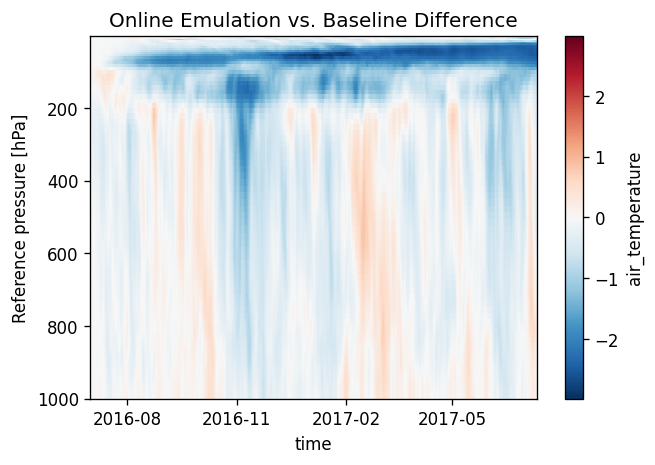

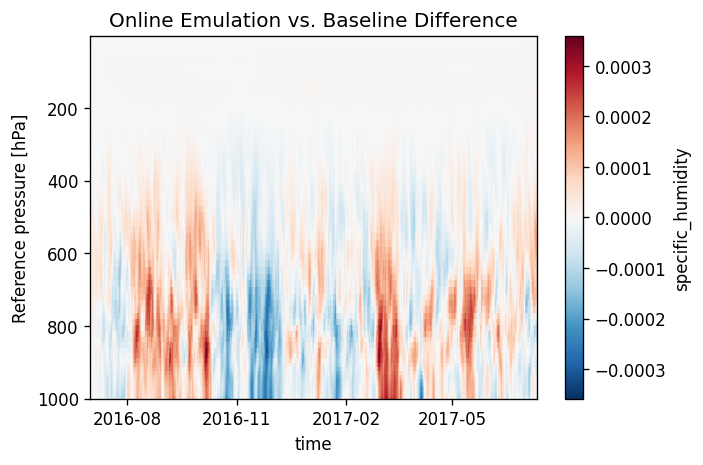

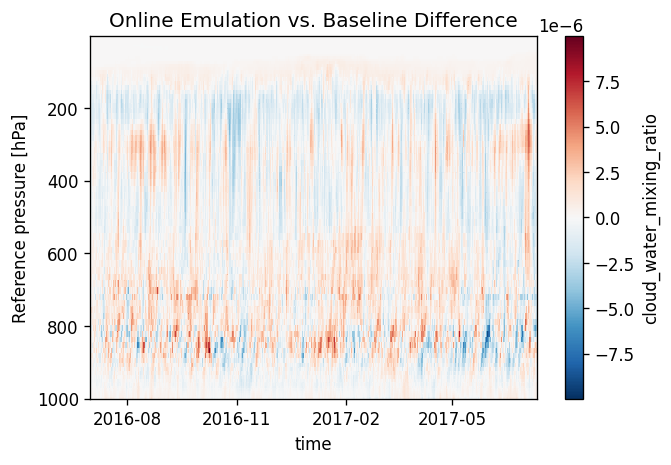

In [14]:
for f in fields:
    if "precip" in f:
        continue
    plt.figure(dpi=120)
    diff[f].plot(y="z", yincrease=False)
    plt.title("Online Emulation vs. Baseline Difference")
    plt.ylabel("Reference pressure [hPa]")
    plt.show()

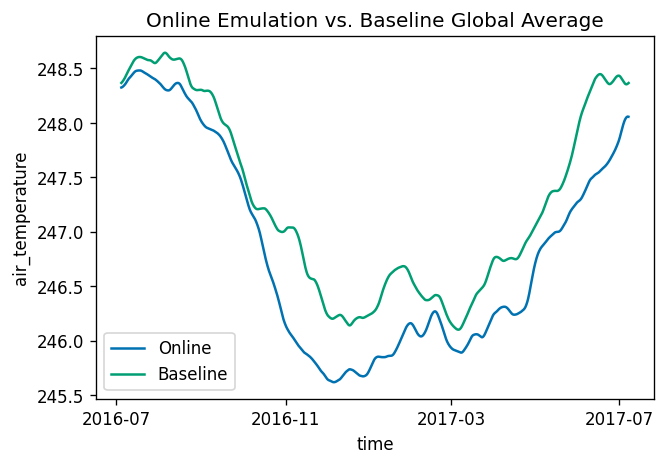

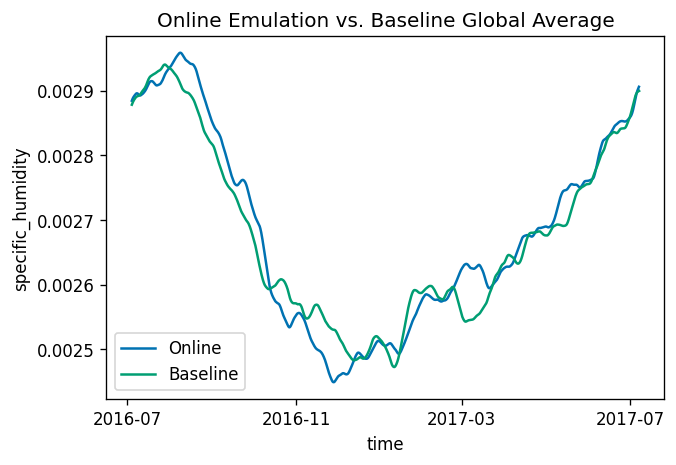

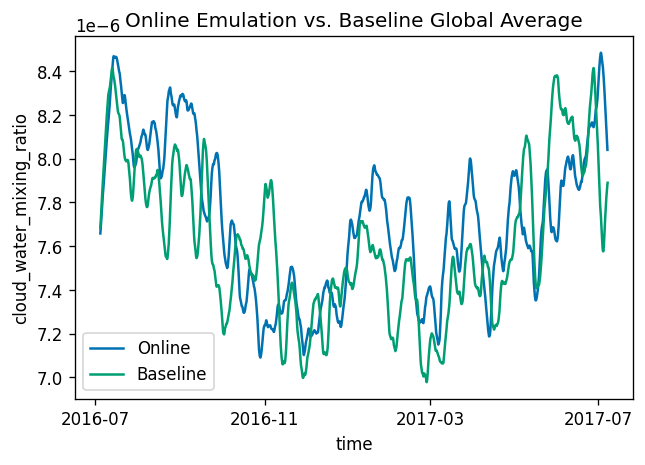

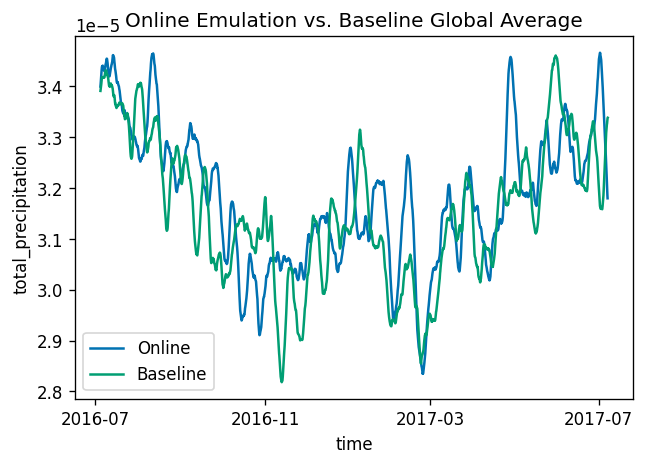

In [15]:
for f in fields:
    plt.figure(dpi=120)
    online.mean(dim="z")[f].rolling(time=7*8, center=True).mean().plot(label="Online")
    offline.mean(dim="z")[f].rolling(time=7*8, center=True).mean().plot(label="Baseline")
    plt.title("Online Emulation vs. Baseline Global Average")
    plt.legend()
    plt.show()

## Hovemoller Diagrams

In [8]:
hov_fields = [
    "total_precipitation",
    "cloud_water_mixing_ratio",
    "PWAT",
    "ULWRFtoa",
    "USWRFtoa",
    "h500",
]

data_source = {
    online_group: common.open_group(online_group),
    offline_group: common.open_group(offline_group)
}

In [17]:
@common.memoize_xarray_out
def get_hovemoller_1yr(group, field):

    data = data_source[group]

    da = data[field]
    if field == "total_precipitation" :
        da = common.m_to_mm_day(da)
    elif field == "cloud_water_mixing_ratio":
        da = vcm.mass_integrate(
            da,
            data["pressure_thickness_of_atmospheric_layer"],
            dim="z"
        )

    da = vcm.zonal_average_approximate(grid.lat, da)

    return da.to_dataset(name=field).load()

In [18]:
online_zonal = [get_hovemoller_1yr(group, field) for group, field in product([online_group], hov_fields)]

In [ ]:

offline_zonal = [get_hovemoller_1yr(group, field) for group, field in product([offline_group], hov_fields)]

In [24]:
online_ds = xr.Dataset({
    field: d["field"] for field, d in zip(hov_fields, online_zonal)
})

offline_ds = xr.Dataset({
    field: d["field"] for field, d in zip(hov_fields, offline_zonal)
})

In [44]:
offline_ds["total_precipitation"].attrs.update({"long_name": "Surface precipitation", "units": "mm/day"})
offline_ds["cloud_water_mixing_ratio"].attrs.update({"long_name": "Column integrated cloud water", "units": "kg/m^2"})

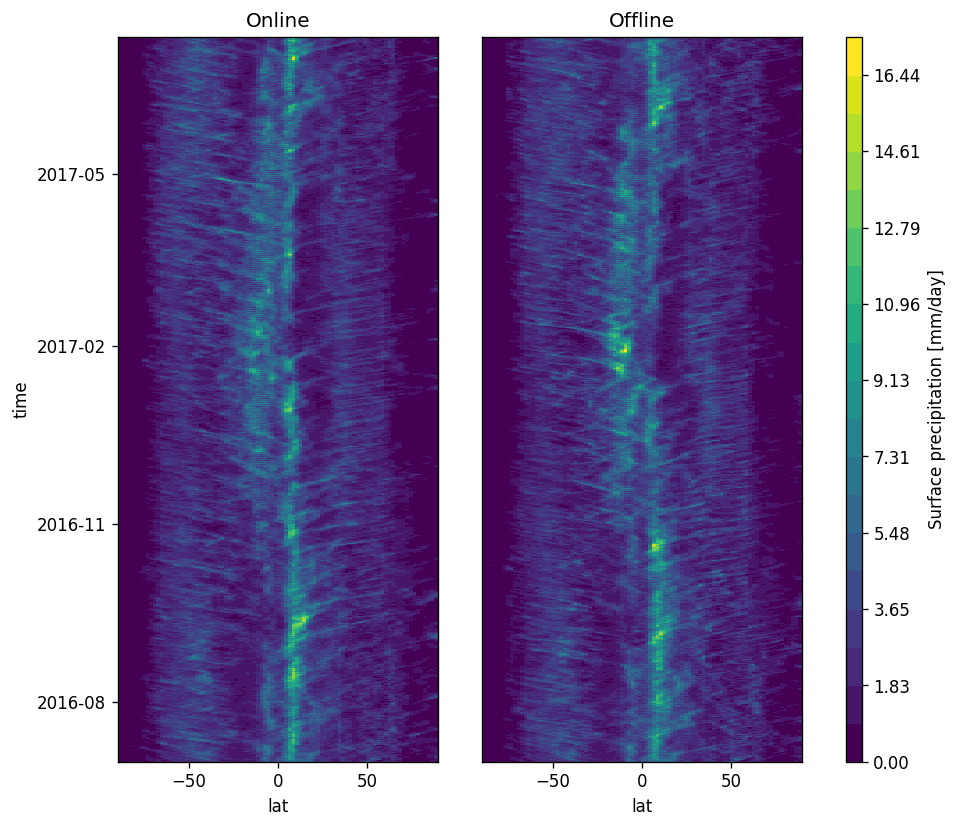

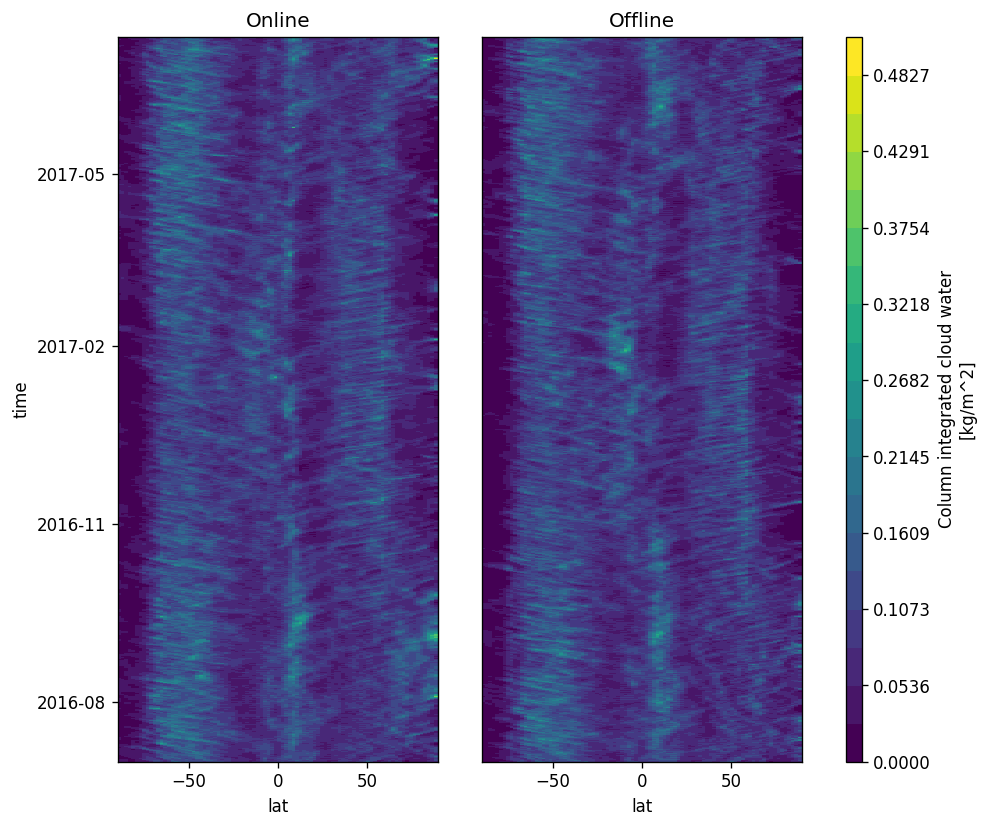

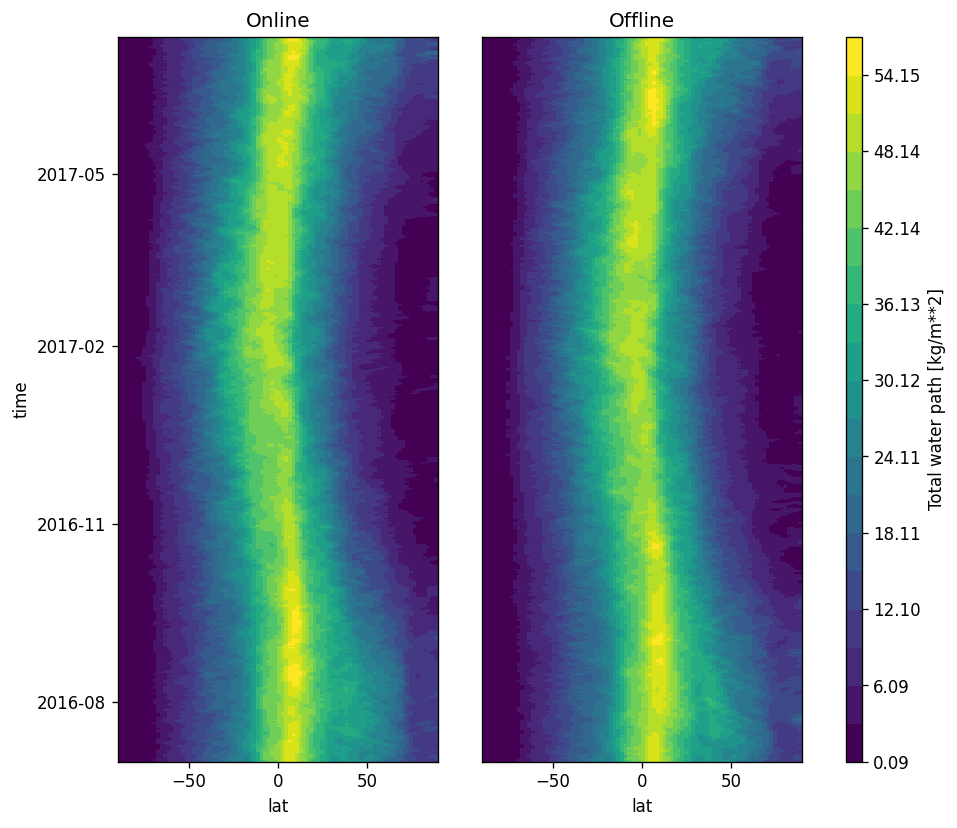

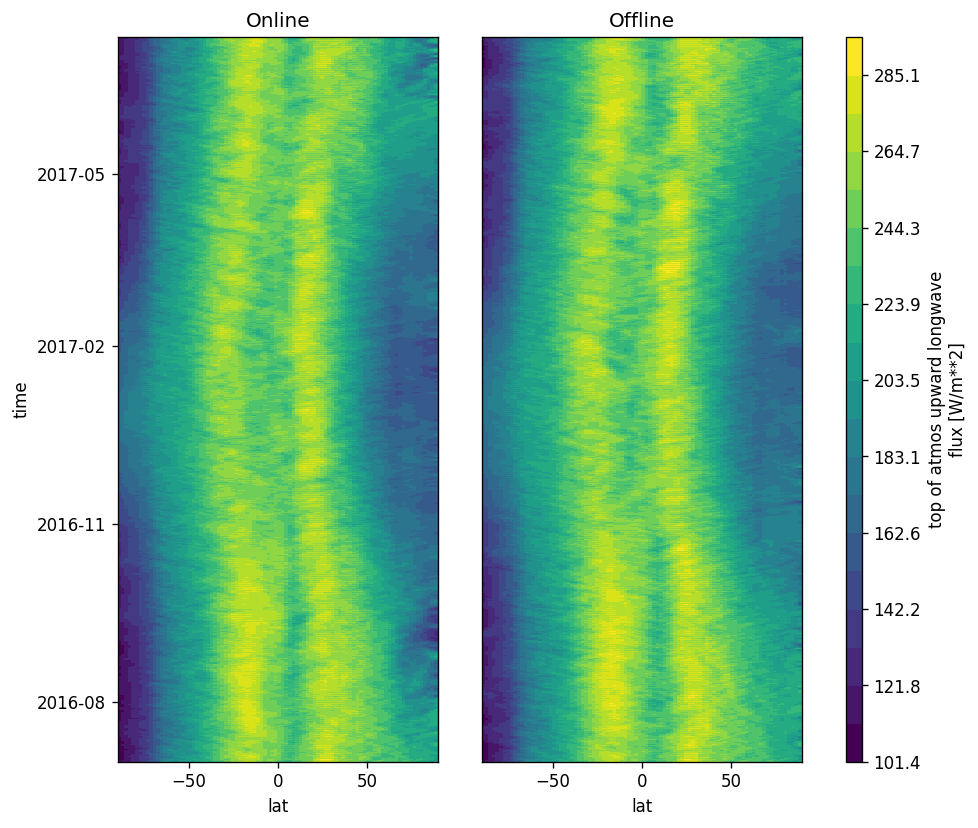

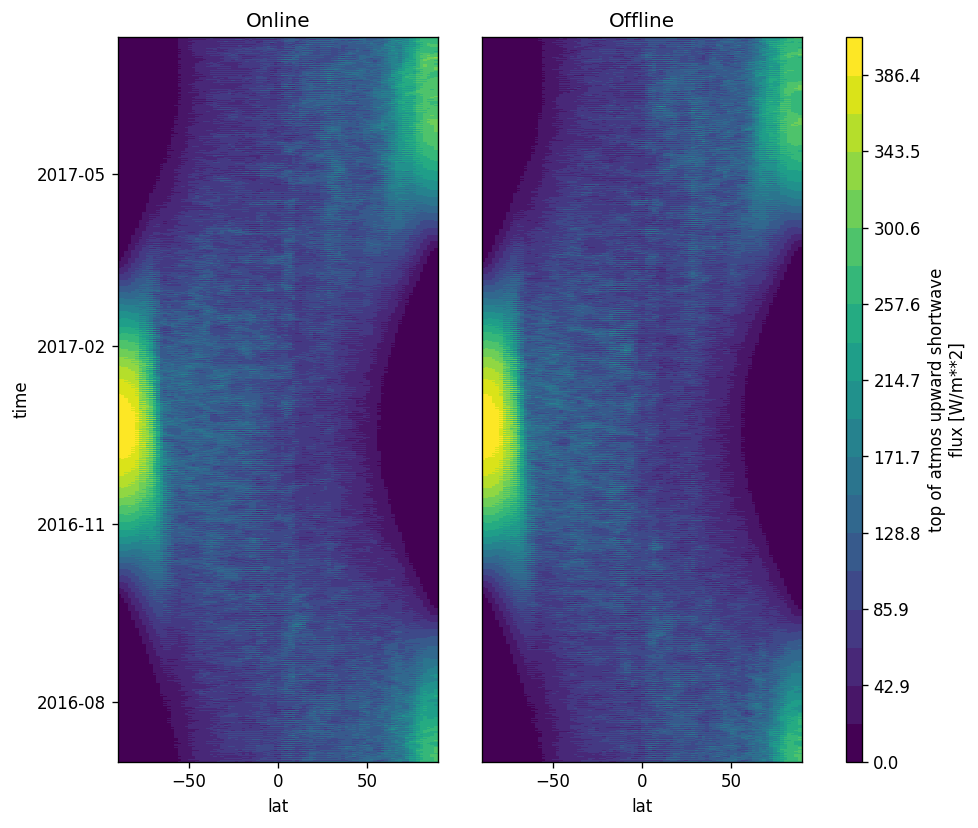

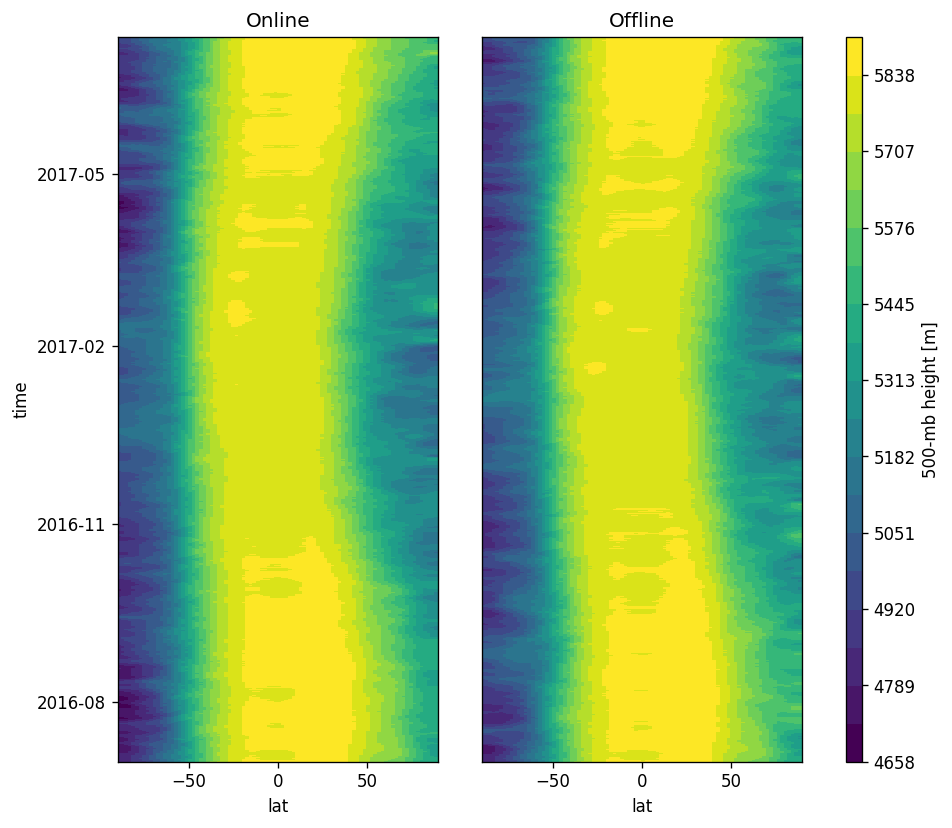

In [45]:
for k, online_v in online_ds.items():
    fig = plt.figure(dpi=120, figsize=(8, 8))
    gs = fig.add_gridspec(1, 3, width_ratios=[20, 20, 1], hspace=0.1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    cbar_ax = fig.add_subplot(gs[2])

    offline_v = offline_ds[k]
    vmin = min(online_v.min(), offline_v.min())
    vmax = max(online_v.max(), offline_v.max())

    online_v.plot(y="time", ax=ax1, vmin=vmin, vmax=vmax, levels=20, add_colorbar=False)
    offline_v.plot(y="time", ax=ax2, vmin=vmin, vmax=vmax, levels=20, cbar_ax=cbar_ax, yticks=[0])
    ax2.set_ylabel("")
    ax1.set_title("Online")
    ax2.set_title("Offline")
    plt.show()

## Zonal Average bias

### Last Month

In [9]:
@common.memoize_xarray_out
def get_zonal_avg_last_3month(group, field):

    data = data_source[group]

    start_time = -1 * 3 * 30 * 8
    da = data[field].isel(time=slice(start_time))

    da = vcm.zonal_average_approximate(grid.lat, da)

    return da.to_dataset(name=field).mean(dim="time").load()

In [10]:
fields

['air_temperature',
 'specific_humidity',
 'cloud_water_mixing_ratio',
 'total_precipitation']

In [16]:
last_3mo_results = [
    get_zonal_avg_last_3month(group, field) 
    for group, field in product(data_source.keys(), fields)
]

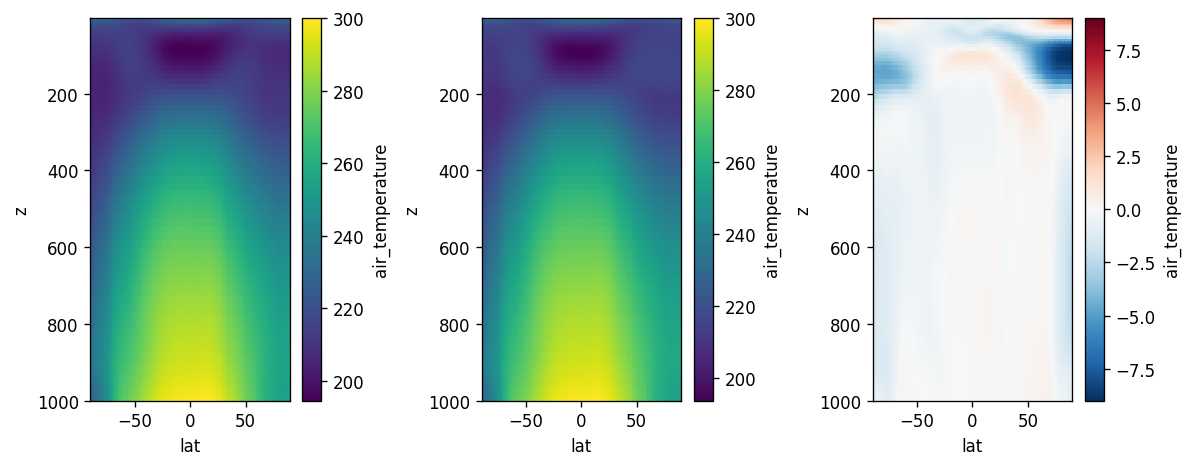

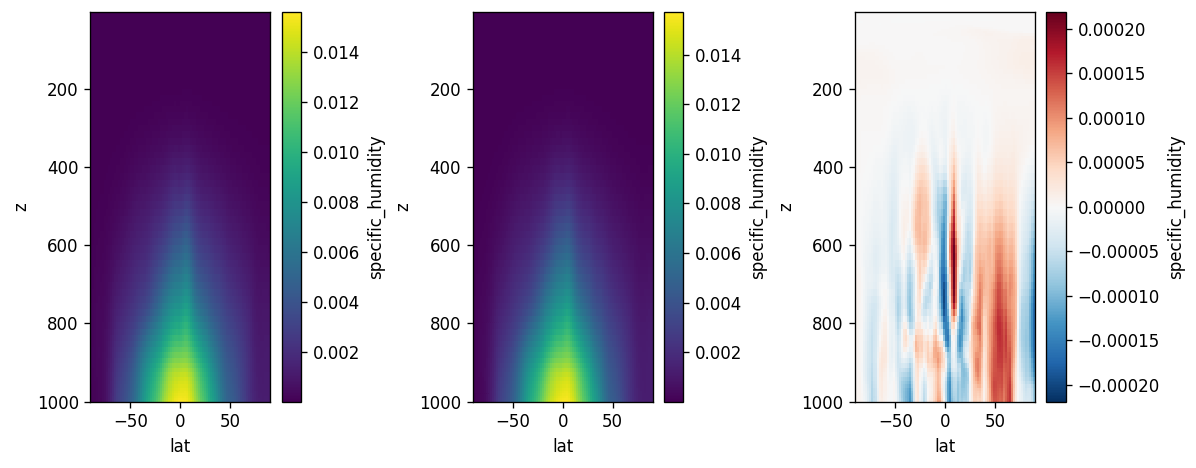

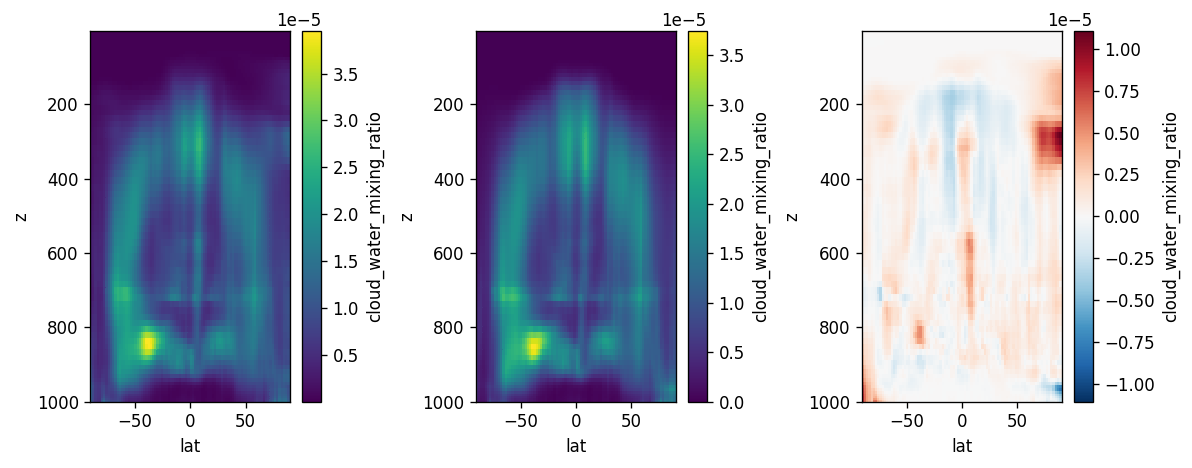

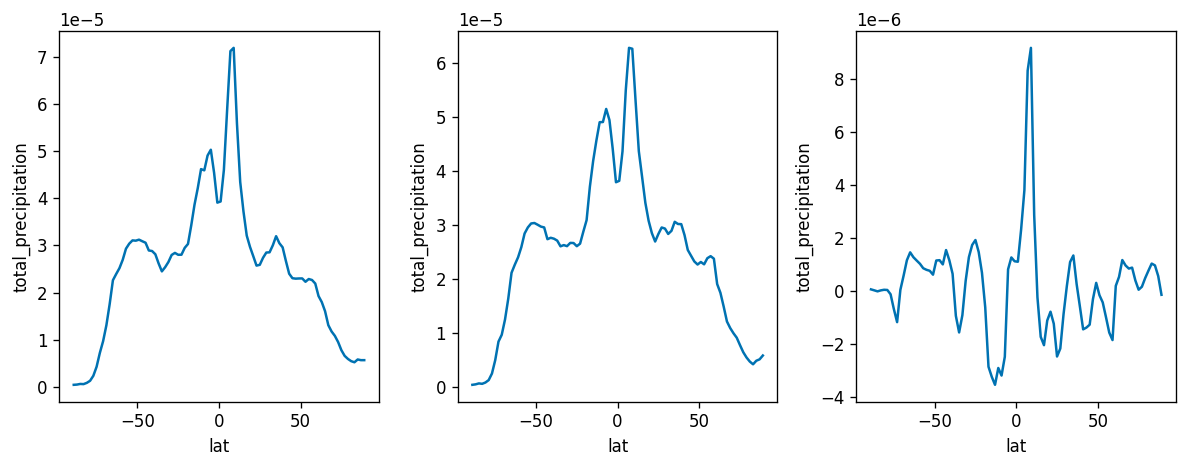

In [24]:
scale_factors = {
    "specific_humidity": 1000,
    "": "s"
}

for i in range(len(fields)):
    online_ds = last_3mo_results[i][fields[i]]
    offline_ds = last_3mo_results[i + len(fields)][fields[i]]

    fix, ax = plt.subplots(1, 3, dpi=120, figsize=(10,4))
    if i != 3:
        kwargs = dict(y="z", yincrease=False)
    else:
        kwargs = {}
    online_ds.plot(ax=ax[0], **kwargs)
    offline_ds.plot(ax=ax[1], **kwargs)
    (online_ds - offline_ds).plot(ax=ax[2], **kwargs)



    plt.tight_layout()
    plt.show()



In [18]:
len(last_3mo_results)

8

In [ ]:
common._get_runs(online_group, "prognostic-eval")